In [1]:
import numpy as np
import pandas as pd
from helper.Loader import Loader
import matplotlib.pyplot as plt
import seaborn as sns
from helper.get_data import pivot_table_all
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex4 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

Cycles
One especially common way for serial dependence to manifest is in cycles. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself. Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior.

In [2]:
database = 'market_research'
table_name = 'ohlc'
start_date = "2012-01-01"
end_date = "2022-01-26"

"""
"""
wind_codes = pd.read_csv('beer.txt',sep=' ', header=None,)
wind_codes = wind_codes[0].to_list()
field = "symbol,date,close"
# options = "PriceAdj=DP"
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
df.head()
table = pivot_table_all(df, 'date', 'symbol', 'close')
# print(table)

Data found!


In [3]:
y = table.loc[:, '600600.SH'].dropna().to_period('D')["2019-01":]
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df

,y,y_lag_1,y_lag_2
date,,,
2019-01-02,57.1514,NaN,NaN
2019-01-03,55.1635,57.1514,NaN
2019-01-04,55.3292,55.1635,57.1514
2019-01-07,57.7478,55.3292,55.1635
2019-01-08,55.4783,57.7478,55.3292
...,...,...,...
2022-02-07,156.0120,156.9820,158.2760
2022-02-08,152.5050,156.0120,156.9820
2022-02-09,155.3820,152.5050,156.0120


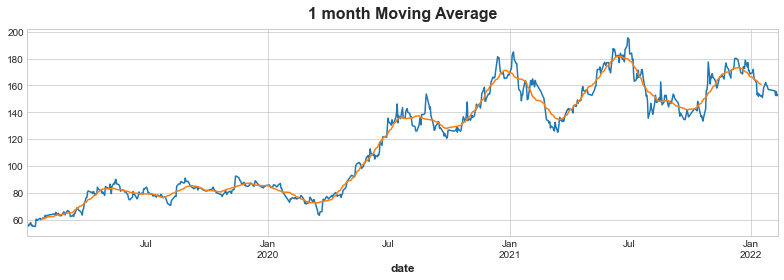

In [4]:
y_ma = y.rolling(30, center=True).mean()
# Plot
ax = y.plot()
ax = y_ma.plot()
ax.set_title("1 month Moving Average");

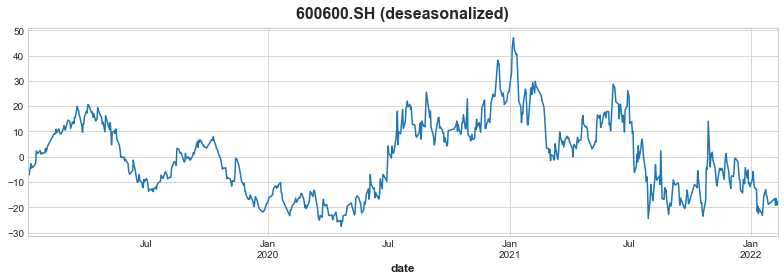

In [5]:
fourier = CalendarFourier(freq='Y', order=12)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = '600600.SH_deseasoned'

ax = y_deseason.plot()
# ax = y.plot()
ax.set_title("600600.SH (deseasonalized)");

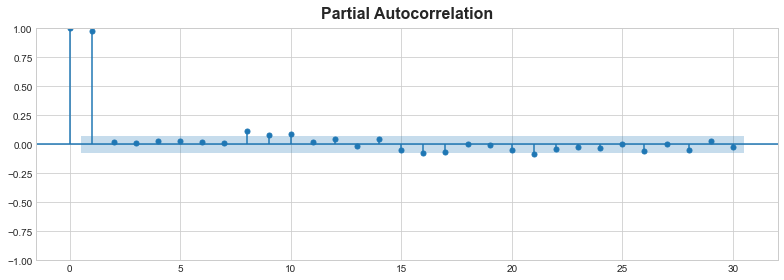

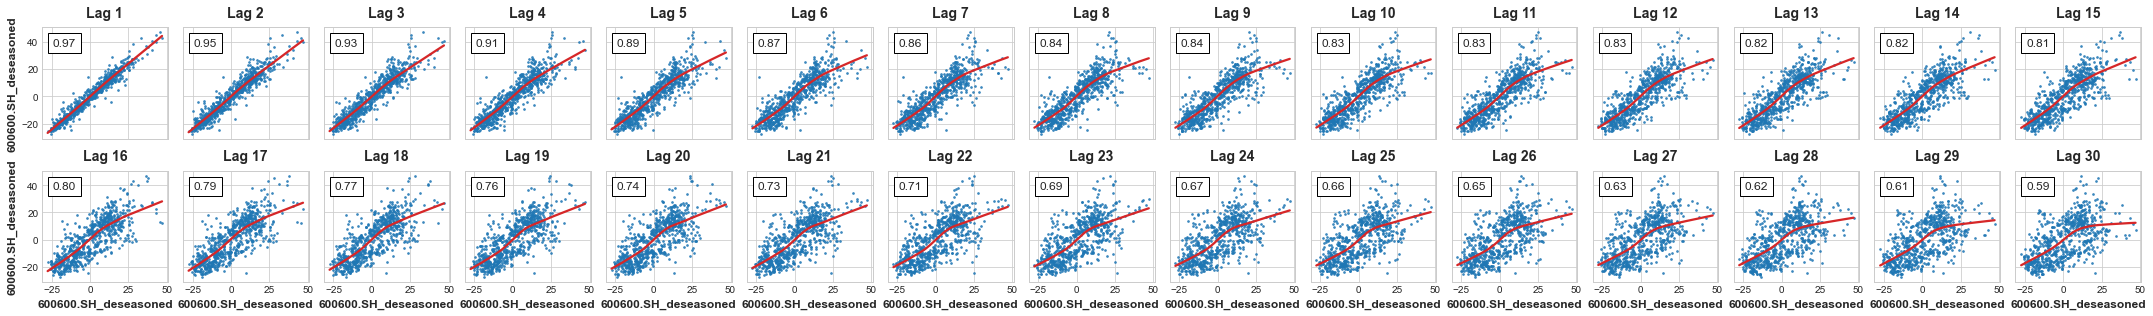

In [6]:
plot_pacf(y_deseason, lags=30);
plot_lags(y_deseason, lags=30, nrows=2);

In [7]:
X_lags = make_lags(y_deseason, lags=1)
X = pd.concat([X_time, X_lags], axis=1).dropna()
y, X = y.align(X, join='inner')
# X_time

Training RMSLE: 0.02597
Validation RMSLE: 0.02115


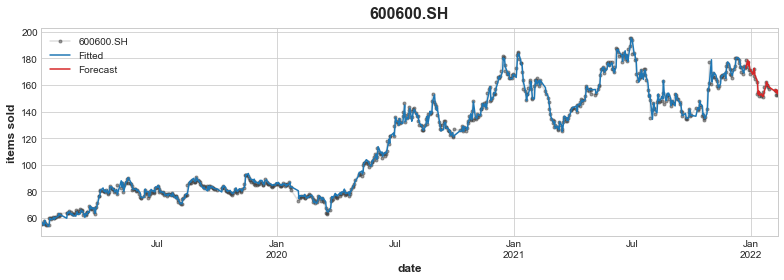

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="600600.SH", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

Create statistical features

y_lag = y.shift(1)
# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# YOUR CODE HERE: 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# YOUR CODE HERE: 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
ewm_7 = y_lag.ewm(7).mean()

# Plot
ax = ewm_7.plot()
ax.set_title("Seven-Day Exponential Moving Average");

In [9]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
# table.stack().squeeze()  

In [10]:
table_name = 'finance_rpt'
field_growth =  "date,symbol,yoyeps_basic,yoyeps_diluted,yoyocfps,yoy_tr,yoy_or,yoyop,yoyop2,yoyebt,yoyprofit,yoynetprofit,yoynetprofit_deducted,dp_yoy,yoyroe,yoyocf,maintenance,yoy_cash,yoy_fixedassets,fa_rdexp_yoy,yoy_equity,yoycf,yoydebt,yoy_assets"
field_profit = "roe_avg,roe_basic,roe_diluted,roe_deducted,roe_exbasic,roe_exdiluted,roe_add,roa2,roa,roic,ROP,roe_yearly,roa2_yearly,roa_yearly,netprofitmargin,netprofitmargin_deducted,grossprofitmargin,cogstosales,nptocostexpense,expensetosales,optoebt,profittogr,optogr,ebittogr,gctogr,operateexpensetogr,adminexpensetogr,finaexpensetogr,impairtoOP,ebitdatosales"
field = field_growth + "," + field_profit
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
df.tail()

Data found!


,date,symbol,yoyeps_basic,yoyeps_diluted,yoyocfps,yoy_tr,yoy_or,yoyop,yoyop2,yoyebt,...,optoebt,profittogr,optogr,ebittogr,gctogr,operateexpensetogr,adminexpensetogr,finaexpensetogr,impairtoOP,ebitdatosales
618,2021-03-31,000752.SZ,77.777778,77.777778,10.0189,105.9290,105.9290,129.0416,6565.830696,125.8361,...,100.734947,3.5618,5.5904,13.1687,91.0766,2.0859,3.9707,7.6191,NaN,NaN
619,2021-06-30,000752.SZ,73.333333,73.333333,90.1996,29.3667,29.3667,151.3599,96.981319,142.4885,...,100.850147,3.9417,5.8179,12.1828,91.2454,2.0472,4.1327,6.4304,NaN,15.697567
620,2021-09-30,000752.SZ,77.272727,77.272727,79.8384,10.2084,10.2084,179.1295,101.503433,159.0703,...,109.620431,4.9646,7.4427,12.7449,90.3741,2.0434,3.9997,5.9553,NaN,NaN
621,2021-12-31,000752.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
622,2022-02-20,000752.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
def holiday2businessday(datelist):
    import QuantLib as ql
    datelist1 = []
    cal = ql.China()
    for date in datelist:
        mydate = ql.Date(date.days_in_month, date.month, date.year)
        while cal.isHoliday(mydate):
            mydate = mydate + ql.Period(1, ql.Days)
        datelist1.append(mydate.ISO())
        # print('Is Holiday :', cal.isHoliday(mydate))
        # print(mydate)
    # print(datelist)
    # print(ax1.index)
    return pd.PeriodIndex(datelist1, freq='D')

# y = table.loc[:, '600600.SH'].dropna().to_period('D')["2019-01":]
y = table.loc[:, '600600.SH'].dropna().to_period('D')["2019-01":]
wind_code = "600600.SH"
finance_rpt = (
    df[df['symbol']==wind_code]
    .set_index('date').to_period('D')["2018-12":]
)
# finance_rpt = finance_rpt[["yoyeps_diluted", "roe_avg"]]
# yoyeps_diluted = finance_rpt["yoyeps_diluted"].dropna().to_frame(name="yoyeps_diluted")
# yoyeps_diluted.index.name = 'date'

finance_rpt.index = holiday2businessday(finance_rpt.index)
# print(finance_rpt.index)

ax1, ax2 = y_deseason.align(finance_rpt, join='left', axis=0)
yoyeps_diluted = ax2["yoyeps_diluted"]
roe_avg = ax2["roe_avg"]
# print(ax1["2019-01-02":])
# print(ax2)
# print(y)

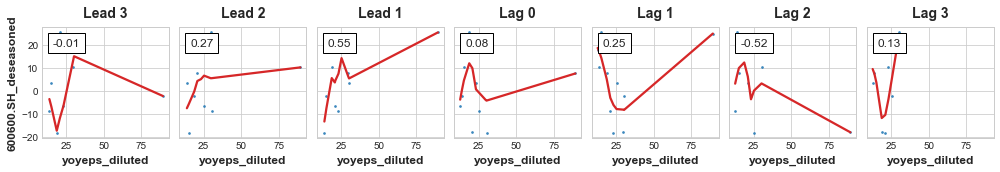

In [12]:
plot_lags(x=yoyeps_diluted.loc[yoyeps_diluted > 0], y=y_deseason.loc[yoyeps_diluted > 0], lags=3, leads=3, nrows=1);

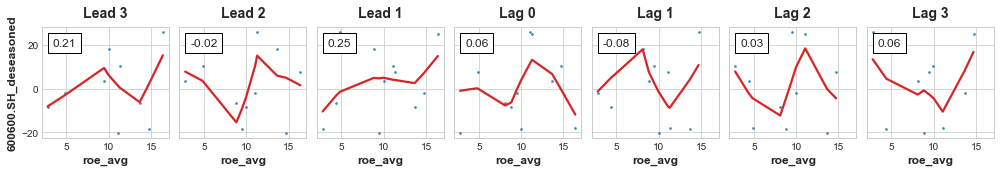

In [13]:
plot_lags(x=roe_avg.loc[roe_avg > 0], y=y_deseason.loc[roe_avg > 0], lags=3, leads=3, nrows=1);

In [14]:
search_terms = ["yoyeps_diluted", "roe_avg"]

# Create three lags for each search term
# X0 = make_lags(flu_trends[search_terms], lags=3)
factors = ax2[search_terms]
X0 = pd.concat([
    make_lags(factors, lags=1),
    factors,
    make_leads(factors, leads=1),
], axis=1)
# X0 = pd.DataFrame()
# Create four lags for the target, as before
X1 = make_lags(y_deseason, lags=1)

# Combine to create the training data
X = pd.concat([X_time, X0, X1], axis=1).fillna(0.0)
y, X = y.align(X, join='inner')

Training RMSLE: 0.02627
Validation RMSLE: 0.02048


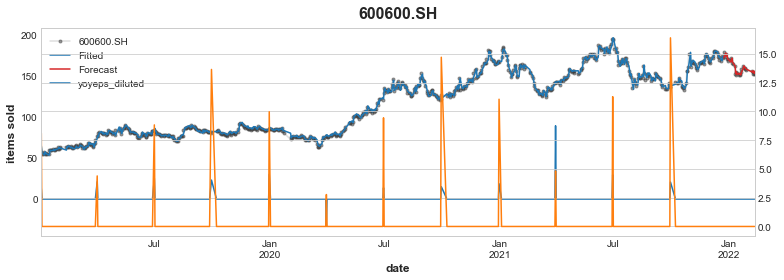

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="600600.SH", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax = X.plot(ax=ax,
    y=["yoyeps_diluted", "roe_avg"],
    secondary_y="roe_avg",
)
ax.legend();

In [28]:
factors.dropna()


,yoyeps_diluted,roe_avg
date,,
2019-01-02,12.620321,8.1001
2019-04-01,21.052632,4.3945
2019-07-01,25.207469,8.8321
2019-09-30,23.166023,13.6544
2019-12-31,30.199430,9.9731
2020-03-31,-33.444816,2.7759
2020-06-30,13.753107,9.4453
2020-09-30,15.099269,14.7159
2020-12-31,18.672502,11.0637
